In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import os

os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from orthogonal_dfa.spliceai.load_model import load_spliceai

from orthogonal_dfa.data.sample_text import sample_text
from orthogonal_dfa.deep_dfa import ProbabilisticAutoma
from orthogonal_dfa.math import corr
from orthogonal_dfa.manual_dfa.stop_codon_dfa import stop_codon_dfa

from orthogonal_dfa.oracle.evaluate import (
    multidimensional_confusion,
    print_metrics,
    pack_as_uint32,
    conditional_mutual_information,
    ConditionalMutualInformation,
    actual_pct_difference_by_prediction,
    evaluate_dfas,
    DEMO_SEED,
)
from orthogonal_dfa.spliceai.load_model import load_spliceai
from orthogonal_dfa.data.exon import default_exon
from orthogonal_dfa.utils.dfa import (
    dfa_symbols_to_num,
    TorchDFA,
    p_to_al,
    dfa_symbols_to_acgt,
)
from orthogonal_dfa.mutation.mutation import RandomSingleMutation

from orthogonal_dfa.algorithms.greedy import greedy_optimize
from orthogonal_dfa.experiments.sensitivity import *

In [5]:
three_stops = stop_codon_dfa(phase_agnostic=True)

In [6]:
three_stops_ta = stop_codon_dfa(("TAG", "TAA"), phase_agnostic=True)

In [7]:
no_orf = stop_codon_dfa()

In [8]:
no_orf_ta = stop_codon_dfa(("TAG", "TAA"))

In [9]:
settings = {
    "no-ORF": (no_orf,),
    "no-ORF-TA": (no_orf_ta,),
    "no-ORF | no-ORF-TA": (no_orf, no_orf_ta),
    "3S": (three_stops,),
    "3S-TA": (three_stops_ta,),
    "no-ORF | 3S": (no_orf, three_stops),
    "no-ORF-TA | 3S": (no_orf_ta, three_stops),
    "no-ORF | 3S-TA": (no_orf, three_stops_ta),
    "no-ORF-TA | 3S-TA": (no_orf_ta, three_stops_ta),
}

In [10]:
rsm = RandomSingleMutation()

In [11]:
len(no_orf.states), len(no_orf_ta.states), len(three_stops.states), len(
    three_stops_ta.states
)

(20, 16, 13, 10)

In [12]:
num_self_loops_each = {
    x: sum(y == x for y in v.values()) for x, v in no_orf.transition_function.items()
}
num_self_loops_each = {k: v for k, v in num_self_loops_each.items() if v}
print(
    f"Num self loops by state: {num_self_loops_each}; total: {sum(num_self_loops_each.values())}"
)

Num self loops by state: {19: 4, 0: 3, 1: 1}; total: 8


In [13]:
model = load_spliceai(400, 0)

In [14]:
count = 1_000_000


def eval_de(d, *c):
    return evaluate_dfas(default_exon, [d], c, model, count=count, seed=DEMO_SEED)[0]

In [15]:
for k, s in settings.items():
    print(k)
    print()
    print_metrics(eval_de(*s))
    print()

no-ORF

Mutual Information:
    0.0482b (0.0476b, 0.0489b)
Actual % Difference by Prediction:
    -35.83% (-36.06%, -35.60%)

no-ORF-TA

Mutual Information:
    0.0642b (0.0634b, 0.0650b)
Actual % Difference by Prediction:
    -30.70% (-30.89%, -30.51%)

no-ORF | no-ORF-TA

Mutual Information:
    0.0102b (0.0099b, 0.0105b)
Actual % Difference by Prediction:
    28.78% (28.66%, 28.89%)

3S

Mutual Information:
    0.0026b (0.0025b, 0.0027b)
Actual % Difference by Prediction:
    -46.61% (-47.35%, -45.83%)

3S-TA

Mutual Information:
    0.0295b (0.0290b, 0.0301b)
Actual % Difference by Prediction:
    -42.38% (-42.67%, -42.09%)

no-ORF | 3S

Mutual Information:
    0.0461b (0.0455b, 0.0468b)
Actual % Difference by Prediction:
    -44.02% (-44.26%, -43.79%)

no-ORF-TA | 3S

Mutual Information:
    0.0627b (0.0619b, 0.0635b)
Actual % Difference by Prediction:
    -53.88% (-54.18%, -53.57%)

no-ORF | 3S-TA

Mutual Information:
    0.0380b (0.0374b, 0.0387b)
Actual % Difference by Predicti

Running sensitivity analysis on 792296689170f7db5c7627bbcb44b9b62d24b48dc387f2d74b3d99c41c5204e0 (controlling for []) using RepeatedMutations(base_mutation=RandomSingleMutation(p_change_accept=0.1), num_serial=1)
1000 0
(1000000,) (1000, 1000000) (0, 1000000)
Running sensitivity analysis on 792296689170f7db5c7627bbcb44b9b62d24b48dc387f2d74b3d99c41c5204e0 (controlling for []) using RepeatedMutations(base_mutation=RandomSingleMutation(p_change_accept=0.1), num_serial=2)
1000 0
(1000000,) (1000, 1000000) (0, 1000000)
Running sensitivity analysis on 792296689170f7db5c7627bbcb44b9b62d24b48dc387f2d74b3d99c41c5204e0 (controlling for []) using RepeatedMutations(base_mutation=RandomSingleMutation(p_change_accept=0.1), num_serial=3)
1000 0
(1000000,) (1000, 1000000) (0, 1000000)
1 0
(1000000,) (1, 1000000) (0, 1000000)
Running sensitivity analysis on d2a189569b8070d635ddc0461d813e274d4c067c36edac12693155ec3f28c3c5 (controlling for []) using RepeatedMutations(base_mutation=RandomSingleMutation(p_

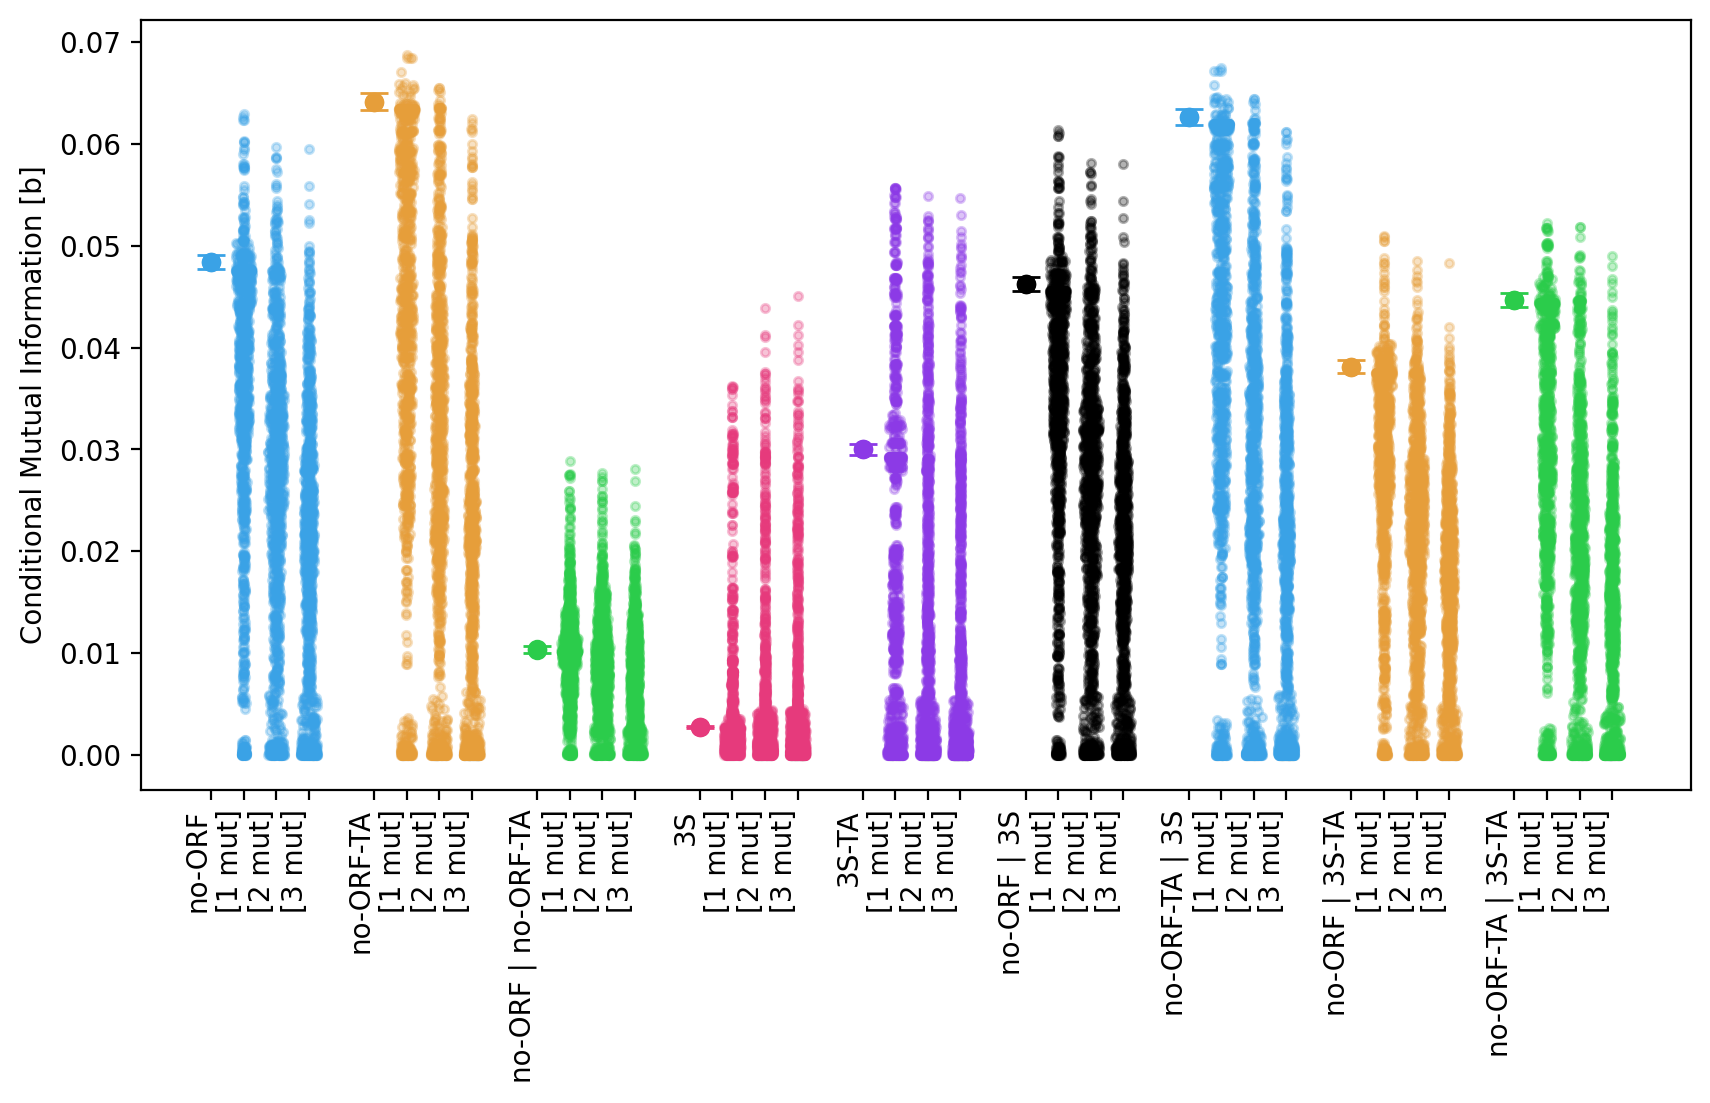

In [18]:
plt.figure(dpi=200, figsize=(10, 5))
plot_sensitivity(
    settings,
    model,
    default_exon,
    1000,
    ConditionalMutualInformation(),
    count=count,
)

In [ ]:
optimal, path = greedy_optimize(
    no_orf_ta,
    default_exon,
    model,
    rsm,
    seed=0,
    scoring=ConditionalMutualInformation(),
    tolerance=0.01,
)

In [ ]:
path

In [ ]:
p_to_al(three_stops)

In [ ]:
p_to_al(three_stops_ta)

In [ ]:
p_to_al(no_orf)

In [ ]:
p_to_al(no_orf_ta)